In [2]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow
import sys


In [4]:
print("python: ", sys.version)
print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("keras: ", keras.__version__)
print("tensorflow: ", tensorflow.__version__)


python:  3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
pandas:  1.3.4
numpy:  1.20.3
seaborn:  0.11.2
matplotlib:  3.5.0
sklearn:  1.0.1
keras:  2.7.0
tensorflow:  2.7.0


In [5]:
class Visualization:
    labels = ["Normal", "Anomaly"]
    
    def draw_anomaly(self, y, error, threshold):
        groupDF = pd.DataFrame({'error': error,
                               'true': y}).groupby('true')
        figure, axes = plt.subplots(figsize=(12, 8))
        
        for name, group in groupDF:
            axes.plot(
                group.index,
                group.error,
                marker='x' if name == 1 else 'o',
                linestyle='',
                color='r' if name == 1 else 'g',
                label="Anomaly" if name == 1 else "Normal"
            )
            
        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1],
                   colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
        
    def draw_error(self, error, threshold):
        plt.figure(figsize=(10, 8))
        plt.plot(
            error,
            marker='o',
            ms=3.5,
            linestyle='',
            label='Point'
        )
        plt.hlines(
            threshold,
            xmin=0,
            xmax=len(error)-1,
            colors="r",
            zorder=100,
            label='Threshold'
        )
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
        
        

In [6]:
tensorlogs = ["art_daily_no_noise", #0
              "art_daily_nojump", #1
              "art_daily_jumpsdown",#2 
              "art_daily_perfect_square_wave", #3 
              "art_increase_spike_density",  #4
              "art_load_balancer_spikes",  #5
              "ambient_temperature_system_failure", #6 
              "nyc_taxi",  #7
              "ec2_cpu_utilization", #8
              "rds_cpu_utilization"] #9 

dataFilePaths = ['data/art_daily_no_noise.csv',
                 'data/art_daily_nojump.csv',
                 'data/art_daily_jumpsdown.csv',
                 'data/art_daily_perfect_square_wave.csv',
                 'data/art_increase_spike_density.csv',
                 'data/art_load_balancer_spikes.csv',
                 'data/ambient_temperature_system_failure.csv',
                 'data/nyc_taxi.csv',
                 'data/ec2_cpu_utilization.csv',
                 'data/rds_cpu_utilization.csv']

In [7]:
tensorlogs

['art_daily_no_noise',
 'art_daily_nojump',
 'art_daily_jumpsdown',
 'art_daily_perfect_square_wave',
 'art_increase_spike_density',
 'art_load_balancer_spikes',
 'ambient_temperature_system_failure',
 'nyc_taxi',
 'ec2_cpu_utilization',
 'rds_cpu_utilization']

In [8]:
dataFilePaths

['data/art_daily_no_noise.csv',
 'data/art_daily_nojump.csv',
 'data/art_daily_jumpsdown.csv',
 'data/art_daily_perfect_square_wave.csv',
 'data/art_increase_spike_density.csv',
 'data/art_load_balancer_spikes.csv',
 'data/ambient_temperature_system_failure.csv',
 'data/nyc_taxi.csv',
 'data/ec2_cpu_utilization.csv',
 'data/rds_cpu_utilization.csv']

In [10]:
i = 7
tensorlog = tensorlogs[i]
dataFilePath = dataFilePaths[i]
print("tensorlog: ", tensorlog)
print("dataFilePath: ", dataFilePath)

tensorlog:  nyc_taxi
dataFilePath:  data/nyc_taxi.csv


In [15]:
df = pd.read_csv(filepath_or_buffer=dataFilePath, 
                header=0,
                sep=',')
print('shape:', df.shape)
print('head:')
print(df.head(5))


shape: (10320, 2)
head:
             timestamp  value
0  2014-07-01 00:00:00  10844
1  2014-07-01 00:30:00   8127
2  2014-07-01 01:00:00   6210
3  2014-07-01 01:30:00   4656
4  2014-07-01 02:00:00   3820


             timestamp  value            Datetime
0  2014-07-01 00:00:00  10844 2014-07-01 00:00:00
1  2014-07-01 00:30:00   8127 2014-07-01 00:30:00
2  2014-07-01 01:00:00   6210 2014-07-01 01:00:00


Text(0.5, 1.0, 'Time Series of value by date time')

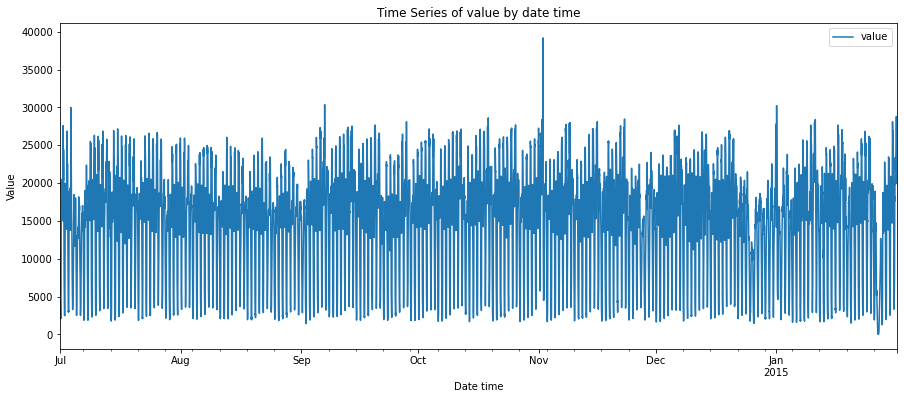

In [18]:
df['Datetime'] = pd.to_datetime(df['timestamp'])
print(df.head(3))
df.shape
df.plot(x='Datetime', y='value', figsize=(15,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

In [19]:
df.value.describe()

count    10320.000000
mean     15137.569380
std       6939.495808
min          8.000000
25%      10262.000000
50%      16778.000000
75%      19838.750000
max      39197.000000
Name: value, dtype: float64

In [20]:
df.Datetime.describe()

/var/folders/xl/8rwkxyws7hn7k9yg46jqxvvw0000gn/T/ipykernel_21319/1499618814.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.Datetime.describe()


count                   10320
unique                  10320
top       2014-07-01 00:00:00
freq                        1
first     2014-07-01 00:00:00
last      2015-01-31 23:30:00
Name: Datetime, dtype: object

<AxesSubplot:title={'center':'Before Scaling'}, xlabel='value', ylabel='Density'>

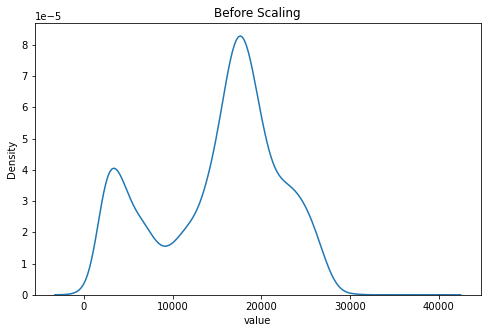

In [21]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8,5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)


In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df['scaled_value'] = pd.DataFrame(
    scaler.fit_transform(
        pd.DataFrame(df['value'])
    ),
    columns=['value']
)
print('shape:', df.shape)
df.head(5)

shape: (10320, 4)


,timestamp,value,Datetime,scaled_value
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,0.276506
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,0.207175
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,0.158259
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00,0.118605
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00,0.097272


<AxesSubplot:title={'center':'After Scaling'}, xlabel='scaled_value', ylabel='Density'>

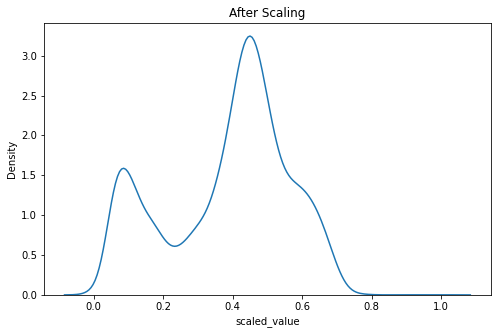

In [23]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)


In [26]:
df.head(5)

,timestamp,value,Datetime,scaled_value
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,0.276506
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,0.207175
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,0.158259
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00,0.118605
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00,0.097272


In [29]:
time_steps = 48

metric = 'mean_absolute_error'
model = Sequential()
model.add(
    LSTM(units=32,
        activation='tanh',
        input_shape=(time_steps, 1),
         return_sequences=True
        )
)
model.add(
    Dense(1, activation='sigmoid')
)
model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=[metric]
)
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 48, 32)            4352      
                                                                 
 dense_2 (Dense)             (None, 48, 1)             33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
sequence = np.array(df['scaled_value'])
print(sequence)


[0.27650616 0.20717548 0.1582587  ... 0.69664957 0.6783281  0.67059634]


In [34]:
time_steps = 48
samples = len(sequence)
trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (
    subsequences, time_steps, 1
)
print(sequence_trimmed.shape)

10320 215
(215, 48, 1)


In [40]:
training_dataset = sequence_trimmed
print("training_dataset:", training_dataset.shape)

batch_size=32
epochs=20

hist = model.fit(
    x=training_dataset,
    y=training_dataset,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(training_dataset, training_dataset),
    callbacks=[
        TensorBoard(log_dir='../logs/{0}'.format(tensorlog))
    ]
)


training_dataset: (215, 48, 1)
Epoch 1/20
7/7 [==============================] - 0s 19ms/step - loss: 0.0181 - mean_absolute_error: 0.0181 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187
Epoch 2/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0180 - mean_absolute_error: 0.0180 - val_loss: 0.0181 - val_mean_absolute_error: 0.0181
Epoch 3/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0179 - mean_absolute_error: 0.0179 - val_loss: 0.0180 - val_mean_absolute_error: 0.0180
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.0178 - mean_absolute_error: 0.0178 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187
Epoch 5/20
7/7 [==============================] - 0s 15ms/step - loss: 0.0176 - mean_absolute_error: 0.0176 - val_loss: 0.0172 - val_mean_absolute_error: 0.0172
Epoch 6/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0175 - mean_absolute_error: 0.0175 - val_loss: 0.0167 - val_mean_absolute_error: 0.0167
Epo

In [41]:
import math
from sklearn.metrics import mean_squared_error

sequence = np.array(df['scaled_value'])
print(sequence)


[0.27650616 0.20717548 0.1582587  ... 0.69664957 0.6783281  0.67059634]


In [63]:
time_steps = 48
samples = len(sequence)
trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]
print(samples, subsequences)
sequence_trimmed.shape = (
    subsequences, time_steps, 1
)
print(sequence_trimmed.shape)

10320 215
(215, 48, 1)


In [64]:
testing_dataset = sequence_trimmed
print("testing_dataset.shape: ", testing_dataset.shape)

testing_pred = model.predict(x=testing_dataset)
print("testing_pred: ", testing_pred.shape)



testing_dataset.shape:  (215, 48, 1)
testing_pred:  (215, 48, 1)


In [65]:
testing_dataset = testing_dataset.reshape(
    (testing_dataset.shape[0]*testing_dataset.shape[1]), 
    testing_dataset.shape[2]
)
print("testing_dataset: ", testing_dataset.shape)



testing_dataset:  (10320, 1)


In [66]:
testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print("testing_pred: ", testing_pred.shape)

testing_pred:  (10320, 1)


In [70]:
errorDF = testing_dataset - testing_pred
print(errorDF.shape)

rmse = math.sqrt(mean_squared_error(testing_dataset, testing_pred))
print('Test RMSE: %.3f' % rmse)


(10320, 1)
Test RMSE: 0.027


In [73]:
dist = np.linalg.norm(
    testing_dataset - testing_pred, axis=1
)
scores = dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.999 * len(scores))
print("cutoff: ", cutoff)
print(scores[cutoff:])

threshold = scores[cutoff]
print(threshold)

(10320,)
cutoff:  10309
[0.19402459 0.19417419 0.1943978  0.19931138 0.19942809 0.20182191
 0.20891494 0.22209935 0.27198517 0.30983436 0.32967912]
0.19402459460460855


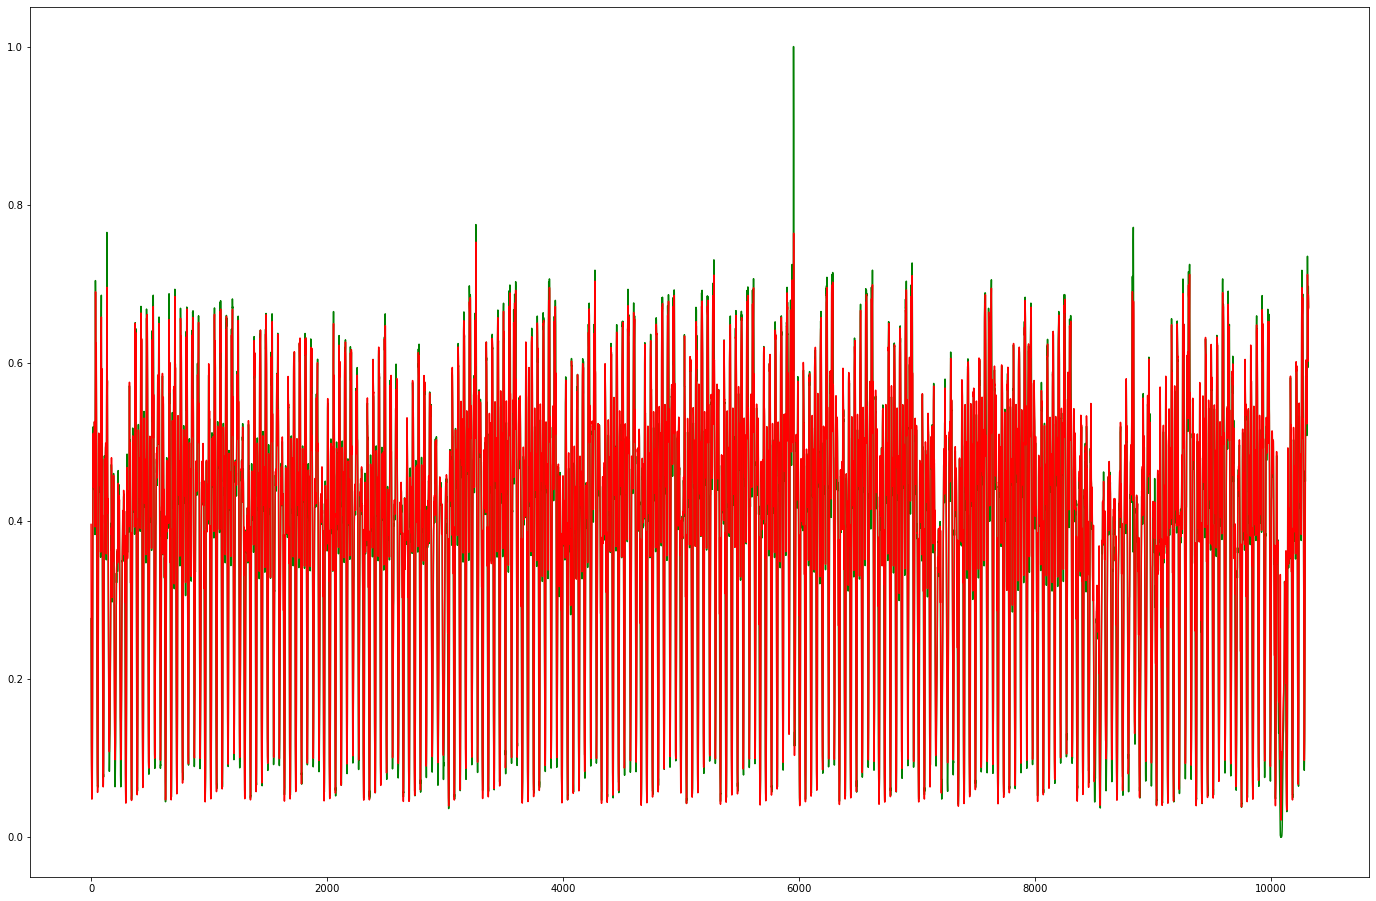

In [74]:
plt.figure(figsize=(24,16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color='red')


In [75]:
z = zip(dist >= threshold, dist)

y_label = []
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)

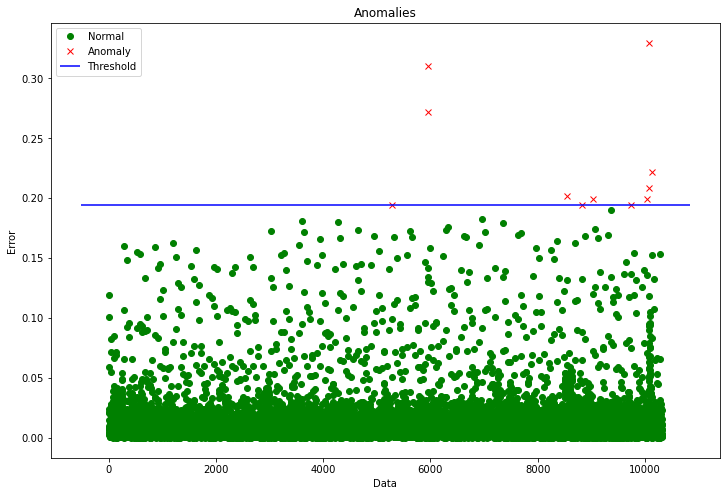

In [82]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)


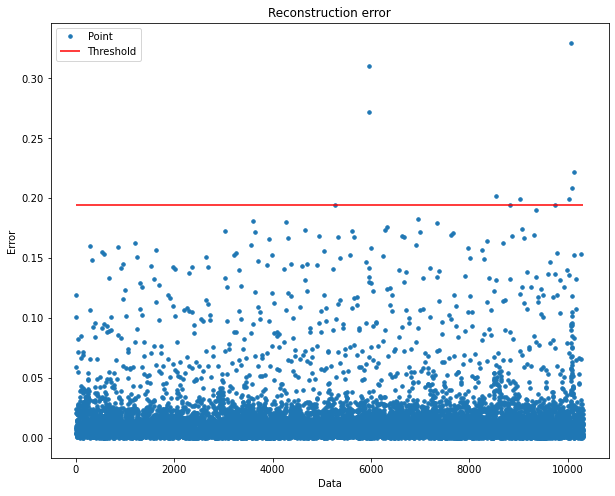

In [83]:
viz.draw_error(error, threshold)


In [97]:
adf = pd.DataFrame({
    'Datetime': df['Datetime'],
    'observation': df['value'],
    'error': error,
    'anomaly': y_label
})
len(adf[adf['anomaly'] == 1])


11

In [98]:
adf.head(5)

,Datetime,observation,error,anomaly
0,2014-07-01 00:00:00,10844,0.119158,0
1,2014-07-01 00:30:00,8127,0.101148,0
2,2014-07-01 01:00:00,6210,0.059638,0
3,2014-07-01 01:30:00,4656,0.024018,0
4,2014-07-01 02:00:00,3820,0.004136,0


Text(0.5, 1.0, 'Time Series of value by date time')

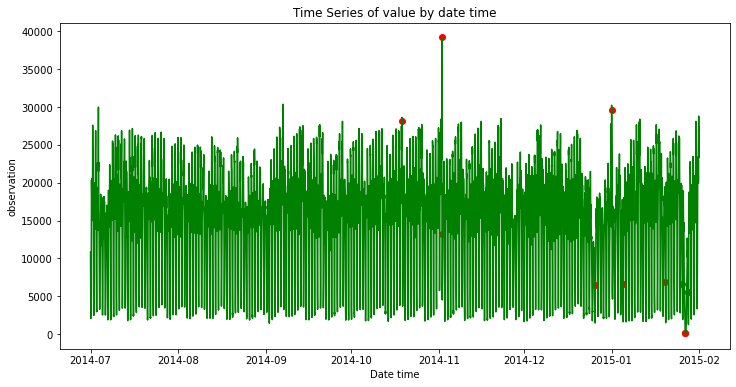

In [99]:
figure, axes = plt.subplots(
    figsize=(12, 6)
)
axes.plot(adf['Datetime'],
         adf['observation'],
         color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(
    anomaliesDF['Datetime'].values,
    anomaliesDF['observation'],
    color='r'
)
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')
